# Explainability of the Models
This Notebook loads and runs the different models and runs explainability methods on them.

Run only the cells for the models you want to investigate.

The next cells run the basic imports and definitions.

**Attention**: Since this file is not on the server it originally belonged, the file references will not work. So at each file reference, there is a comment describing what is expected, so the code can be easily used as is.

Here is a list of all locations, where a file path should be added for full functionallity: "Explainability of the Models" the second cell (two references), "Models" all four models, "Images" in "original images" one reference, "Images" in "segmented images" two references, "Images" in "dcgan images" one reference

In [1]:
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.dataset import Dataset
import glob
import pandas as pd
from torch import optim, nn
import os.path
from os import path
from collections import OrderedDict
import time
import os
import json
from matplotlib.colors import LinearSegmentedColormap

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLiftShap
from captum.attr import GradientShap
from captum.attr import InputXGradient
from captum.attr import GuidedBackprop
from captum.attr import Deconvolution

In [2]:
# List of labels
label_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation',
              'Infiltration','Fibrosis','Pneumonia','No Finding']

def resolve_full_path(img_name):
    is_found = False
    dcgan_is_found = False

    # Read 1 image file
    folder_idx_range = 13
    img_path = ''
    for folder_idx in range(folder_idx_range):########## REFERENCE ##########
        # REFERENCE: Path reference to the main file data base. The NIH-images look like this: data/images_[Number with 0 digits]/images/[Here are the images]
        path_prefix = path.expanduser("~/data/kaggle/nih-chest-xrays/data/images_")  
        path_suffix = "images/"
        cur_img_dir = path_prefix +str(folder_idx).zfill(3) +'/'
        img_folder_path = path.join(cur_img_dir, path_suffix)
        img_path = os.path.join(img_folder_path, img_name)
        if(path.exists(img_path)):
            is_found = True
            break
            
    if(not is_found):                    ########## REFERENCE ##########
        # REFERENCE: Reference to DCGAN synthetic images. Should look like this: /dcgan_images/[disease name like Cardiomegaly]/[Here are the images]
        path_prefix = glob.glob("./../medical_ip/NIH_code/DCGAN_NIH/dcgan_image/*")
        for path_folder in path_prefix:
            img_path = os.path.join(path_folder, img_name)
            if(os.path.exists(img_path)):
                dcgan_is_found = True
                break
        if not dcgan_is_found:
            raise Exception('Couldn\'t find: {} last:{}'.format(img_name, img_path))
    return img_path
        
class DatasetFromCSV(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.data_len = len(self.data.index)            # csv data length
        
        self.image_names = np.array(self.data.iloc[:,0])  # image names
        self.heights = np.asarray(self.data.iloc[:,8])    # heights are at 8th column 
        self.widths =  np.asarray(self.data.iloc[:,7])    # widths are at  7th column
        
        # createa a tensor to store labels
        self.labels = torch.zeros(self.data_len, 15)
        labels = self.data.loc[:,'Finding Labels'].map(lambda x: x.split('|'))
        self.multi_hot_encoding_label(labels)
    
        self.transform = transform
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        # Read 1 image name
        img_name = self.image_names[index]
        img_path = resolve_full_path(img_name)
        img_as_img = Image.open(img_path)

        img_as_img = img_as_img.convert("RGB")
        # Transform image to tensor
        img_as_tensor = self.transform(img_as_img)

        # Read 1 label:
        image_label = self.labels[index]

        return img_as_tensor, image_label
    
    def multi_hot_encoding_label(self, labels):
            for i,label in enumerate(labels):
                for idx in range(len(label_list)):
                    if label_list[idx] in label:
                        self.labels[i][idx] = 1
     
    
    
# Iterate through all_labels to calculate each case's weight
def calculate_weight(data):
    D_single_weight = calculate_single_label_weight(data)
    weight = torch.zeros(data.shape[0])
    
    all_labels = data.loc[:,'Finding Labels'].map(lambda x: x.split('|'))
    for i, labels in enumerate(all_labels):
        for ii, label in enumerate(labels):
            weight[i] += D_single_weight[label]
    
    return weight

def calculate_single_label_weight(data):
    # Calculate single label weight
    D_sorted = count_label(data)
    D_single_weight = D_sorted.copy()
    for i, label in enumerate(D_single_weight.keys()):
        D_single_weight[label] = 1.0/D_single_weight[label]*1e5
        
    return D_single_weight

def count_label(data):
    D_label_count = dict()
    all_labels = data.loc[:,'Finding Labels'].map(lambda x: x.split('|'))
    for i,labels in enumerate(all_labels):
        for ii, label in enumerate(labels):
            D_label_count[label] = D_label_count.get(label, 0) + 1
    D = D_label_count
    D_sorted = OrderedDict(sorted(D.items(), key=lambda x: x[1], reverse=True))
    
    return D_sorted

# Define transforms
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Define transforms
transform2 = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

# Models
Choose one of the models listed below and choose the fitting images and Neural Network. The descriptions tell what you need to chose with which model.

**Original image Network:**

Uses original images and Normal ResNet18 model.

In [3]:
########## REFERENCE ##########
# Reference to the trained models weights. This is of the original model, which uses only original images
model_path = "./../medical_ip/trained_models/trained_model_resenet18_multi_class_multi_label.pt"

**Segmented images Network:**

Uses Segmented images only and Normal ResNet18 model.

In [ ]:
########## REFERENCE ##########
# Reference to the trained models weights. This is of the model, which uses only segmented images
model_path = "./../medical_ip/trained_models/model_resenet18_multi_class_multi_label_k_fold_segmentation.pt"

**Segmented + Original images Network:**

Uses Segmented and Original images. Choose one of them. Uses Normal ResNet18 model.

In [ ]:
########## REFERENCE ##########
# Reference to the trained models weights. This is of the model, which uses original and segmented images
model_path = "./../medical_ip/trained_models/model_resenet18_multi_class_multi_label_k_fold_segmentationandoriginal.pt"

**DCGAN + Original images Network:**

Uses DCGAN an Original images. Choose one of them. Uses ResNet50 model.

In [ ]:
########## REFERENCE ##########
# Reference to the trained models weights. This is of the model, which uses original and dcgan images
model_path = "./../medical_ip/trained_models/resnet18_dcgan_kfold.pt"

# Neural Networks
There are two network setups available. Choose the one fitting to the model selected above.

**Normal ResNet18 Model**

This model is used by the original images, the segmented images and the segmented + original images.

In [4]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ",device)

def create_model():
    
    # Import pre-trained densenet-121
    model = models.resnet18(pretrained=True)

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    # Change output to classfiy 14 conditioins + nothing.
    # Change a new classifier
    model.fc = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 15)
    )
    return model

Using device:  cuda


**ResNet50 Model**

This model is used by the DCGAN + Original images.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ",device)

def create_model():
    
    # Import pre-trained resnet
    model = models.resnet50(pretrained=True)

    for name, param in model.named_parameters(): # all requires_grad by default, are True initially
        if ('layer2' in name) or ('layer3' in name) or ('layer4' in name) or ('fc' in name):
            param.requires_grad = True 
        else:
            param.requires_grad = False

 
    # Change output to classfiy 14 conditioins + nothing.
    # Change a new classifier
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 15),
#         nn.ReLU(),
#         nn.Dropout(0.2),
#         nn.Linear(256, 15)
    )
    
    return model

Using device:  cuda


# Images

In the next parts the images will be loaded. *Use only one image set*

**Original images**

These cells load original images. The batch size can be set here.

To change the image, change the *cur* to a number between 0 and batch_size

In [10]:
# Define custom data loader
                            ########## REFERENCE ##########
# Reference to a csv, which contains the images and diseases. The look of there specific csv is:

# Image Name (name of image like 00000003_004.png)
# Finding Labels (name of diseases seperated with "|")
# Follow Up # (number of how many images there are for the patient id)
# Patient ID (number)
# Patiennt Age (number)
# Patent Gender (F or M)
# View Position (Not sure, something like PA, AP)
# Original Image width (pixel number of image width)
# Original Image height (pixel number of image height)
# original image pixel spacing x and y (two values, spacing of pixel like 0.143)

# Only Image name, labels, width and height are used 
dataset_path = './../medical_ip/Multi_Label_Dataloader_and_Classifier/valdata_paul.csv'
valid_dataset = DatasetFromCSV(dataset_path ,transform=transform)
valid_dataset2 = DatasetFromCSV(dataset_path ,transform=transform2)
batch_size_ = 50
cur = 0 # Change your current image here. Must be between 0 and batch_size_

# Load the images two times with different transform
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                batch_size=batch_size_,
                                                num_workers=6,
                                                shuffle=False)

valid_loader2 = torch.utils.data.DataLoader(dataset=valid_dataset2,
                                                batch_size=batch_size_,
                                                num_workers=6,
                                                shuffle=False)

image, label = next(iter(valid_loader))
image_t, label_t = next(iter(valid_loader2))

**Segmented Image**

This code loads segmented images. You can specify the image with the image_number below. The image_number specifies the line in the csv, so it must be bigger 0.

In [7]:
def resolve_full_path_seg(img_name):
    is_found = False

    # Read 1 image file
    folder_idx_range = 3
    img_path = ''
    for folder_idx in range(folder_idx_range): ########## REFERENCE ##########
        # Reference to segmented images. They look like this: images/images_[number with 3 digits]/[here are the images]
        path_prefix = path.expanduser("./../Anupama/medical_ip/NIH_code/Preprocessing_Segmentation/images/images_")
        cur_img_dir = path_prefix +str(folder_idx).zfill(3) +'/'
        img_path = os.path.join(cur_img_dir, img_name)

        if(path.exists(img_path)):
            is_found = True
            break
    if(not is_found):
        
        raise Exception('Couldn\'t find: {} last:{}'.format(img_name, img_path))
    return img_path

def load_seg(x, trans):          ########## REFERENCE ##########
    # Reference to a csv containing two columns: Image name (name of image like 00000010_000.png), Finding labels (disease names seperated with "|")
    f = open("./../Anupama/medical_ip/NIH_code/Preprocessing_Segmentation/ValData_Segmented.csv")
    for i, line in enumerate(f):
        if i == x:
            parts = line.split(",")
            img_name = parts[0]
            
            labels = torch.zeros(1, 15)
            labels_tmp = parts[1].rstrip("\n").split("|")
            
            for idx in range(len(label_list)):
                if label_list[idx] in labels_tmp:
                    labels[0][idx] = 1
        
            img_path = resolve_full_path_seg(img_name)
            print(img_path)
            img_as_img = Image.open(img_path)

            img_as_img = img_as_img.convert("RGB")
            # Transform image to tensor
            img_as_tensor = trans(img_as_img)

            return img_as_tensor.unsqueeze(0), labels
    print("Error: Line number not found")
    return None, None
cur = 0 # This must stay 0 in this case

In [26]:
image_number = 4
image, label = load_seg(image_number, transform) # load the x-th image with transform and normilization and only transform below
image_t, label_t = load_seg(image_number, transform2)

./../Anupama/medical_ip/NIH_code/Preprocessing_Segmentation/images/images_002/00000088_000.png
./../Anupama/medical_ip/NIH_code/Preprocessing_Segmentation/images/images_002/00000088_000.png


**DCGAN Image**

This part loads DCGAN images. You can specify the csv below. Must be between 0 and 4 (inclusive) and correspond to *Cardiomegaly, Consolodation, Emphysema, Pleural Thickening, Pneumothorax*. The image_number specifies the line in the corresponding csv and should be larger 0.

In [7]:
def load_dcgan(csv, x, trans):    ########## REFERENCE ##########
    # Reference to dcgan csv. This list contains all csv names, which are at the same location specified in the next line.
    # The csvs contain two columns: Image Index (image name like before), Finding labels (Diseases seperated with "|")
    csvs = ["dcgan_Cardiomegaly.csv", "dcgan_Consolidation.csv", "dcgan_Emphysema.csv", "dcgan_Pleural_Thickening.csv", "dcgan_Pneumothorax.csv"]
    f = open("./../medical_ip/NIH_code/DCGAN_NIH/dcgan_image_csv/" + csvs[csv])
    for i, line in enumerate(f):
        if i == x:
            parts = line.split(",")
            img_name = parts[0]
            
            labels = torch.zeros(1, 15)
            labels_tmp = parts[1].rstrip("\n").split("|")
            
            for idx in range(len(label_list)):
                if label_list[idx] in labels_tmp:
                    labels[0][idx] = 1
        
            img_path = resolve_full_path(img_name)
            print(img_path)
            img_as_img = Image.open(img_path)

            img_as_img = img_as_img.convert("RGB")
            # Transform image to tensor
            img_as_tensor = trans(img_as_img)

            return img_as_tensor.unsqueeze(0), labels
    print("Error: Line number not found")
    return None, None
cur = 0 # This must be 0 in this case

In [8]:
image_number = 342
csv = 0  # 0, 1, 2, 3, 4
image, label = load_dcgan(csv, image_number, transform) # load the x-th image with transform and normilization and only transform below
image_t, label_t = load_dcgan(csv, image_number, transform2)

./../medical_ip/NIH_code/DCGAN_NIH/dcgan_image/Cardiomegaly/Cardiomegaly_006_041.png
./../medical_ip/NIH_code/DCGAN_NIH/dcgan_image/Cardiomegaly/Cardiomegaly_006_041.png


# Classification
This code classifies the chosen image on the chosen model. The output is delivered below. After the classification, the Explainability approaches can be run.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(50, 15)
(50, 15)
Predicted: [-3.7264156  -3.278095   -1.4719567  -5.7578483  -2.2424207  -2.347612
 -1.9880624  -2.9005349  -2.4894867  -5.2248797  -3.105439   -1.590187
 -3.3295813  -4.7863426  -0.36913043]
Predicted sigmoid: [0.02351282 0.03633035 0.18664539 0.00314796 0.09600525 0.08725578
 0.12046201 0.05212713 0.0765985  0.00535221 0.04288346 0.1693576
 0.0345702  0.00827389 0.40875116]
Actual: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Predicted Max : -0.3691304326057434
Actual Max : 1.0
Predicted Sigmoid Arg Max : 14
Actual Arg Max : 11
-0.36913043

image batch shape:  torch.Size([50, 3, 224, 224])
single image shape:  torch.Size([3, 224, 224])

Index of Sickness: (array([11]),)
img_1channel shape:  (224, 224)
img_3channel shape: torch.Size([224, 224, 3])
img_1channel shape:  (224, 224)
img_3channel shape: torch.Size([224, 224, 3])
labels: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0

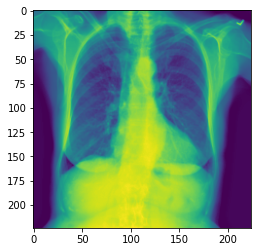

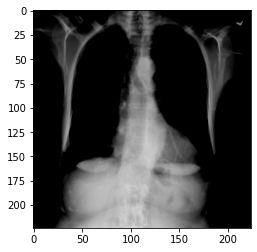

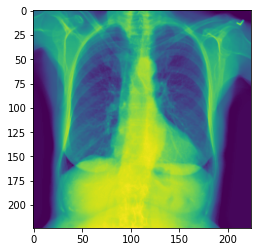

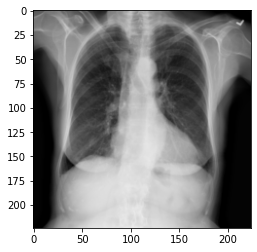

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

model = create_model()
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()

data = image.to('cpu')
# forward pass: compute predicted outputs by passing inputs to the model
output = model(data)
output = output.to('cpu').detach().numpy()
target = label.to('cpu').detach().numpy()

print(np.shape(target))
print(np.shape(output))

print("Predicted: {}".format(output[cur]))
print("Predicted sigmoid: {}".format(sigmoid(output[cur])))

print("Actual: {}".format(target[cur]))

print("Predicted Max : {}".format(output[cur].max()))
print("Actual Max : {}".format(target[cur].max()))

print("Predicted Sigmoid Arg Max : {}".format(sigmoid(output[cur]).argmax()))
print("Actual Arg Max : {}".format(target[cur].argmax()))

print(output[cur].max())
print("\nimage batch shape: ", image.shape)
print("single image shape: ", image[cur].shape)

pred_label_idxs = np.where(target[cur] == 1.0)
print("\nIndex of Sickness: {}".format(pred_label_idxs))


# 1 channel image
img_1_channel = image.numpy()[cur][1]
print("img_1channel shape: ", img_1_channel.shape)
plt.figure()
plt.imshow(img_1_channel)

# 3 channel image
plt.figure()
img_3_channel = image[cur].permute(1, 2, 0)
plt.imshow(img_3_channel, cmap='cool')
print("img_3channel shape:", img_3_channel.shape)

# 1 channel image
img_1_channel2 = image_t.numpy()[cur][1]
print("img_1channel shape: ", img_1_channel2.shape)
plt.figure()
plt.imshow(img_1_channel2)

# 3 channel image
plt.figure()
img_3_channel2 = image_t[cur].permute(1, 2, 0)
plt.imshow(img_3_channel2, cmap='cool')
print("img_3channel shape:", img_3_channel2.shape)

# print label
print("labels:",label)

pred_label_idx = int(pred_label_idxs[0][0]) # select a sickness from the list
print("selected disease index:",pred_label_idx)

default_cmap = LinearSegmentedColormap.from_list('custom purple', 
                                                 [(0, '#000000'),
                                                  (0.25, '#220022'),
                                                  (0.5, '#CC00CC'),
                                                  (0.95, '#FFFFFF'),
                                                  (1, '#FFFFFF')], N=256)

default_cmap2 = LinearSegmentedColormap.from_list('custom grad', 
                                                 [(0, '#FF0000'),
                                                  (0.5, '#000000'),
                                                  (1, '#00FF00')], N=256)

default_cmap3 = LinearSegmentedColormap.from_list('custom red', 
                                                 [(0, '#000000'),
                                                  (0.95, '#FF0000'),
                                                  (1, '#FFAAAA')], N=256)

# Explainability
Here the Explainability approaches are shown. Most of them show the original image first, then an overlay of the attribution. After that a mask of the original image with the attribution and lastly the attribution itself.

When changing the image, make sure to run the classification again, otherwise the explainability might not work.

**Integrated Gradients**

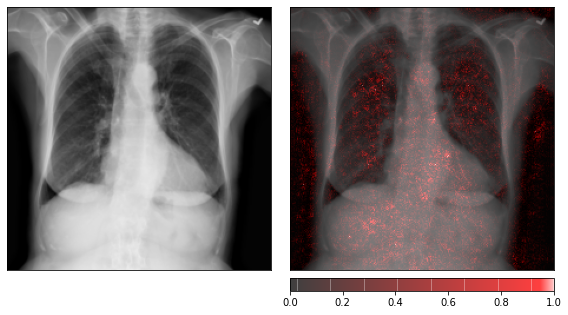

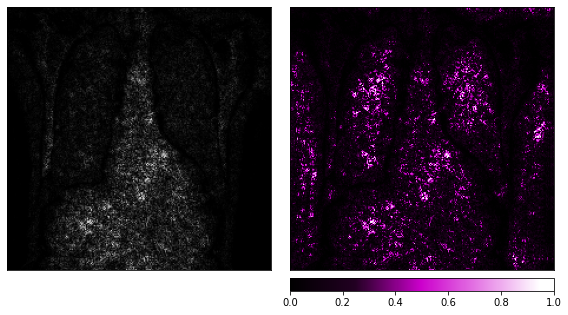

In [7]:
torch.manual_seed(0)
np.random.seed(0)

integrated_grad = IntegratedGradients(model)


attributions_ig = integrated_grad.attribute(data[cur].unsqueeze(0),
                                          target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap3,
                                      show_colorbar=True)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["masked_image", "heat_map"],
                                      ["absolute_value", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

**Saliency Map**

/group/donut/venv/pytorch-venv/lib/python3.6/site-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


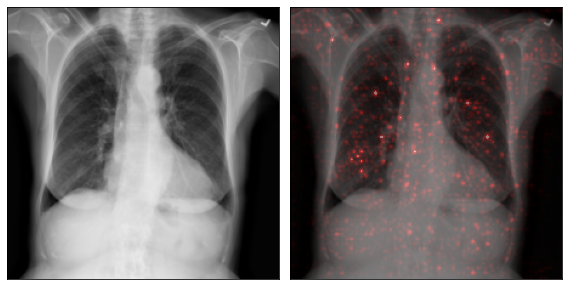

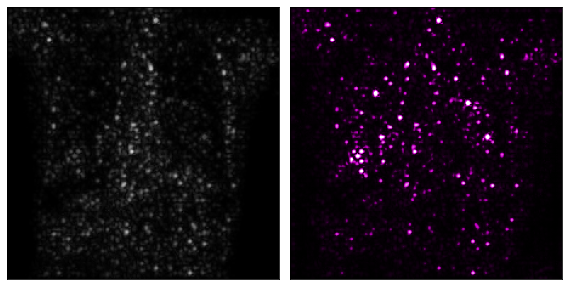

In [8]:
torch.manual_seed(0)
np.random.seed(0)

saliency = Saliency(model)

attributions_s = saliency.attribute(data[cur].unsqueeze(0),
                                  target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_s.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap3,
                                      show_colorbar=False)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_s.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["masked_image", "heat_map"],
                                      ["absolute_value", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=False)

**DeepLiftShap**

ATTENTION: For some reason this one kills the kernel, so the first line has an error to stop it from accidentally running it. You can try to run it, it should have the right parameters.

In [9]:
print(errorSoThatThisDoesNotKillTheKernel)

torch.manual_seed(0)
np.random.seed(0)

deeplift_shap = DeepLiftShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([data * 0, data * 1])

attributions_dls = deeplift_shap.attribute(data[cur].unsqueeze(0),
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_dls.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap3,
                                      show_colorbar=False)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_dls.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["masked_image", "heat_map"],
                                      ["absolute_value", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=False)

NameError: name 'errorSoThatThisDoesNotKillTheKernel' is not defined

**GradientShap**

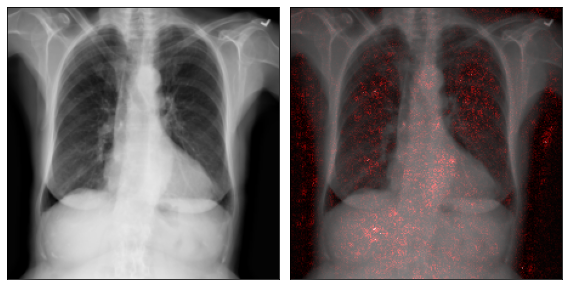

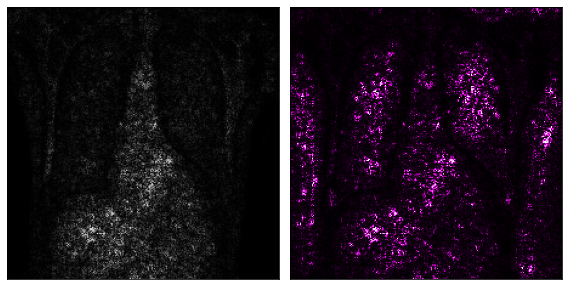

In [10]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([data * 0, data * 1])

attributions_gs = gradient_shap.attribute(data[cur].unsqueeze(0),
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap3,
                                      show_colorbar=False)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["masked_image", "heat_map"],
                                      ["absolute_value", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=False)

**InputXGradient**

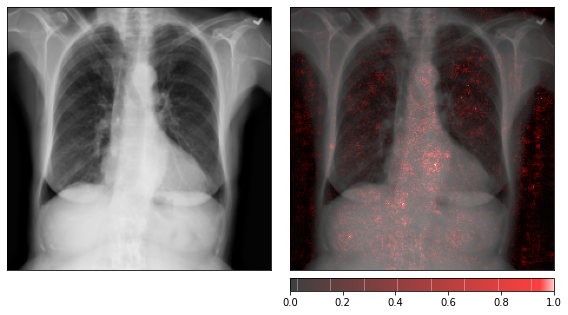

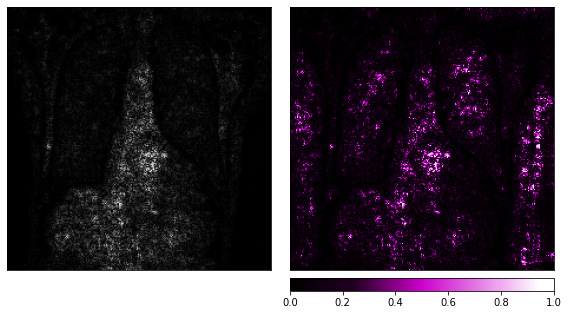

In [11]:
torch.manual_seed(0)
np.random.seed(0)

inputxgrad = InputXGradient(model)

attributions_ixg = inputxgrad.attribute(data[cur].unsqueeze(0),
                                          target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ixg.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap3,
                                      show_colorbar=True)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ixg.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["masked_image", "heat_map"],
                                      ["absolute_value", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

**Guided Backprop**

/group/donut/venv/pytorch-venv/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


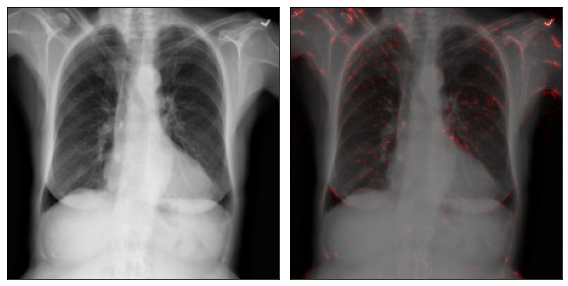

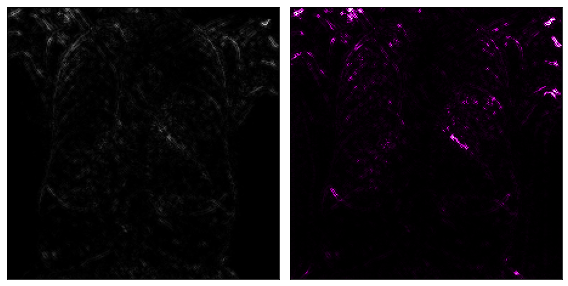

In [12]:
torch.manual_seed(0)
np.random.seed(0)

guided_backprop = GuidedBackprop(model)

attributions_gb = guided_backprop.attribute(data[cur].unsqueeze(0),
                                  target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gb.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap3,
                                      show_colorbar=False)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gb.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["masked_image", "heat_map"],
                                      ["absolute_value", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=False)

**Deconvolution**

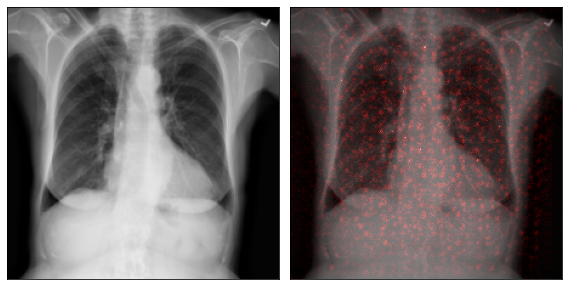

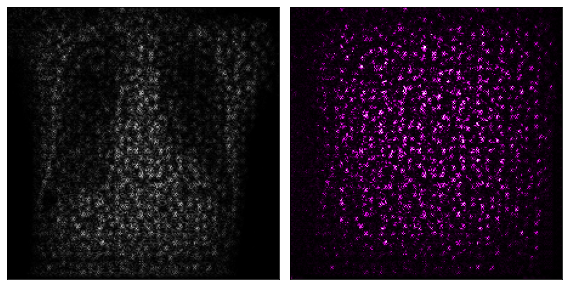

In [13]:
torch.manual_seed(0)
np.random.seed(0)

deconv = Deconvolution(model)

attributions_d = deconv.attribute(data[cur].unsqueeze(0),
                                  target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_d.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "blended_heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap3,
                                      show_colorbar=False)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_d.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_t[cur].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["masked_image", "heat_map"],
                                      ["absolute_value", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=False)